# **CNN with PyTorch**

In [ ]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [ ]:
#CUDA available?
torch.cuda.is_available()

True

In [ ]:
#Transform operation to normalized torch.FloatTensor
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

In [ ]:
#Downloading datasets
train_data = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [ ]:
#Spliting data
len_train=len(train_data)
index = list(range(len_train))
np.random.shuffle(index)
split = int(np.floor(0.2*len_train)) 
train_idx, valid_idx = index[split:], index[:split]

In [ ]:
#Samplers and Dataloaders
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=30,sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=30,sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=30,sampler = train_sampler)

In [ ]:
#image classes
cls = ['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
#helper function to un-normalize and display
def imshow(img):
  img = img /2 + 0.5
  plt.imshow(np.transpose(img,(1,2,0)))

In [ ]:
#loading the first batch
for images,labels in train_loader:
  break

In [ ]:
images = images.numpy()

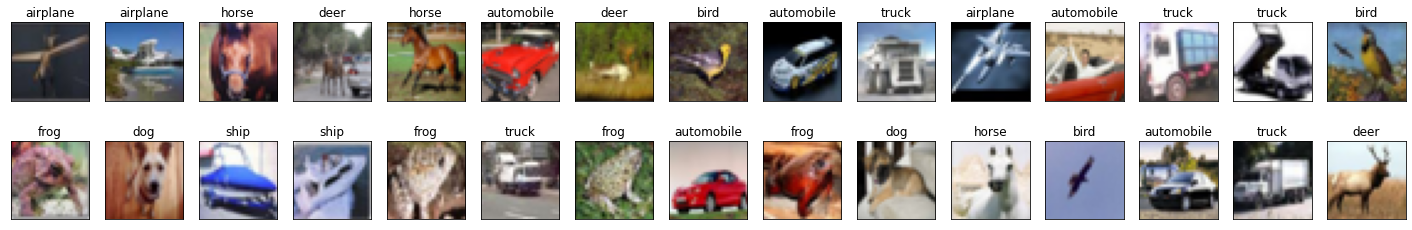

In [ ]:
fig = plt.figure(figsize=(25,4))
for idx in np.arange(30):
  ax = fig.add_subplot(2,30/2,idx+1,xticks=[],yticks=[])
  imshow(images[idx])
  ax.set_title(cls[labels[idx]])

In [ ]:
images[0].shape

(3, 32, 32)

In [ ]:
#Creating the CNN
import torch.nn as nn
import torch.nn.functional as F

class CNN (nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.conv1=nn.Conv2d(3,16,3,1)
    self.conv2= nn.Conv2d(16,32,3,1)
    self.conv3= nn.Conv2d(32,64,3,1)
    ##Aquí la dimensión no debería ser 4*4*64??
    self.fc1 = nn.Linear(2*2*64,125)
    self.fc2 = nn.Linear(125,10)
    #self.fc3 =nn.Linear(50,10)
    self.dropout = nn.Dropout(0.20)
    self.pool = nn.MaxPool2d(2,2)
  
  def forward(self,X):
    X = F.relu(self.conv1(X))
    X = self.pool(X)
    X = F.relu(self.conv2(X))
    X = self.pool(X)
    X = F.relu(self.conv3(X))
    X = self.pool(X)
    X = X.view(-1,2*2*64)
    X = self.dropout(X)
    X = F.relu(self.fc1(X))
    X = self.dropout(X)     
    X = self.fc2(X)
    #X = self.fc3(X)
    return F.log_softmax(X,dim=1)

In [ ]:
#Instantiate the model, define loss and opt func
import torch.optim as optim
torch.manual_seed(101)
model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

In [ ]:
print(model)

CNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
#Sending the model to CUDA
if torch.cuda.is_available():model.cuda()

### **Training**

In [ ]:
#defining number of epochs
epochs = 30

for epoch in range(1, epochs+1):

  train_loss = 0.0
  valid_loss = 0.0

  #training
  model.train()
  for data, target in train_loader:
      if torch.cuda.is_available(): data, target = data.cuda(), target.cuda()
      optimizer.zero_grad()
      out = model(data)
      loss = criterion(out,target)
      loss.backward()
      optimizer.step()
      train_loss += loss.item()*data.size(0)

   #validation
  model.eval()
  for data, target in valid_loader: 
     if torch.cuda.is_available(): data, target = data.cuda(), target.cuda()
     out = model(data)
     loss = criterion(out,target)
     valid_loss += loss.item()*data.size(0)

  #average losses
  train_loss = train_loss/len(train_loader.sampler)
  valid_loss = valid_loss/len(valid_loader.sampler)

  #print statistics
  print('Epoch: {} \tTraining Loss: {} \tValidation Loss: {}'.format(epoch, train_loss, valid_loss))

Epoch: 1 	Training Loss: 2.3030509493350984 	Validation Loss: 2.3029061665534973
Epoch: 2 	Training Loss: 2.301711490690708 	Validation Loss: 2.301480190038681


KeyboardInterrupt: ignored

# **Using a Pretrained Model**

In [ ]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225].

In [ ]:
#Transform operation to normalized torch.FloatTensor
train_trans = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [ ]:
train_data2 = datasets.CIFAR10('data', train=True, download=True, transform=transform)
test_data2 = datasets.CIFAR10('data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
#Spliting data
len_train=len(train_data)
index = list(range(len_train))
np.random.shuffle(index)
split = int(np.floor(0.2*len_train)) 
train_idx, valid_idx = index[split:], index[:split]

In [ ]:
#Samplers and Dataloaders
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=30,sampler = train_sampler)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=30,sampler = valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=30,sampler = train_sampler)

In [ ]:
cls = ['airplane', 'automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
for param in model.parameters():
  param.requires_grad=False

In [ ]:
model.classifier = nn.Sequential(nn.Linear(9216,1024), nn.ReLU(),nn.Dropout(0.4),nn.Linear(1024,10),nn.LogSoftmax(dim=1))

In [ ]:
#Sending the model to CUDA
if torch.cuda.is_available():model.cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.classifier.parameters(),lr=0.001)

In [ ]:
import time
start_time = time.time()

epochs = 10
train_losses = []
test_losses = []
train_correct = []
test_correct = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
   
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        if torch.cuda.is_available(): X_train, y_train = X_train.cuda(), y_train.cuda()
        # Apply the model
        y_pred = model(X_train)
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        predicted = torch.max(y_pred.data, 1)[1]
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%1000 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/50000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = model(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
        
print(f'\nDuration: {time.time() - start_time:.0f} seconds') # print the time elapsed      

RuntimeError: ignored